In [1]:
%matplotlib inline
import pprint as pp

import matplotlib.pyplot as plt
import pandas as pd
import teotil2 as teo

plt.style.use("ggplot")

# TEOTIL2 tutorial 01: Basic principles

This notebook introduces the basic principles of TEOTIL2, an export-coefficient-based model for simulating water-borne chemical fluxes within a catchment network. We will first create a "fake" dataset to illustrate the required input data format and then explore some features of the model's output. 

At the core of the TEOTIL2 framework is a representation of the Norwegian "**regine**" catchment network, encoded as a **directed acyclic graph (DAG)**. Each regine catchment is a **node** in this network and TEOTIL2 makes it easy to assign properties (such as diffuse or point chemical inputs) to each node. These properties can then be **accumulated** downstream, allowing for parameter-specific **retention** in each catchment, if desired.

The TEOTIL2 model itself is both simple and flexible: given an input file, it can easily be used to simulate fluxes for *any* parameter of interest. The hard part is usually finding data to estimate meaningful **input fluxes** and **retention coefficients** for each parameter in each regine catchment. 

## 1. Create a "fake" input file

The code below creates a minimal input file for use with the model. See the files in

    ../data/core_input_data
    
for additional files that were originally compiled for TEOTIL1, and which are now also used by the "nutrients version" of TEOTIL2. 

### 1.1. Required parameters

As a bare minimum, TEOTIL2 requires a "**contingency table**" (also known as an "adjacency matrix") describing the catchment hierarchy. The model also requires estimates for the area of each regine unit (`a_reg_km2`), the average annual runoff (`runoff_mm/yr`), the average flow (`q_reg_m3/s`) and the total lake volume within the subcatchment (`vol_lake_m3`). All this information for the regine catchment network is available from input files originally compiled for TEOTIL1, which are read by the code below.

**Note:** The values for runoff and discharge in this dataset are long-term historic averages. For most applications, they will need adjusting to match the time period of interest, but this is not considered here.

In [2]:
# Read basic regine info
csv_path = r"../data/core_input_data/regine_2018_onwards.csv"
df = pd.read_csv(csv_path, sep=";")
df.drop(
    ["q_sp_m3/s/km2", "vassom", "komnr", "fylke", "ospar_region"],
    axis="columns",
    inplace=True,
)

# Read lake areas
csv_path = r"../data/core_input_data/lake_areas.csv"
la_df = pd.read_csv(csv_path, sep=";")

# Estimate lake volume using the (poor) relationship from TEOTIL1
la_df["mean_lake_depth_m"] = 1.8 * la_df["a_lake_km2"] + 13
la_df["vol_lake_m3"] = la_df["mean_lake_depth_m"] * la_df["a_lake_km2"] * 1e6
la_df.drop(["mean_lake_depth_m", "a_lake_km2"], axis="columns", inplace=True)

# Join
df = pd.merge(df, la_df, how="left", on="regine")
df.fillna(0, inplace=True)

df.head()

,regine,regine_ned,a_reg_km2,runoff_mm/yr,q_reg_m3/s,vol_lake_m3
0,001.,1_2,0.00,0.000,0.00000,0.000
1,001.10,001.,1.41,441.504,0.01974,0.000
2,001.1A1,001.10,1.16,441.504,0.01624,0.000
3,001.1A20,001.1A1,0.35,315.360,0.00350,0.000
4,001.1A2A,001.1A20,17.40,378.432,0.20880,1598010.258


### 1.2. Optional/user-defined parameters

In addition to the standard/required parameters described above, useres can define their own parameters for accumulation over the network. For example, a user may add an additional columns specifying the industrial point input of copper in each regine subcatchment, or the background contribution of total phosphorus from agriculture etc.

The following two rules **must** be adherred to when adding new parameters:

 1. New column names should be **all lowercase** and use the naming convention `{source}_{par}_{unit}`. In particular, the last two components in the name **must** be `{par}_{unit}` (separated by an underscore). For example, `ind_cu_tonnes` might represent inputs of copper from industry, while `agri_tot-p_tonnes` might indicate agricultural inputs of phosphorus. Note that a name such as `all_point_tot-n_tonnes` would also be valid - as long as underscores are used to separate `{source}`, `{par}` and `{unit}`, and `{par}_{unit}` occupy the last two positions, everything should be OK
 
 2. For each parameter, you must also define a **transmission factor** column named `trans_{par}`. All values must lie in the (closed) interval **between 0 and 1**. For each parameter, these numbers represent the proportion of the accumulated load in each regine catchment that is transmitted downstream. Note that transmission is equal to `(1 - retention)`
 
In the code below, we add two hypothetical parameters, `parx` and `pary`, representing **diffuse** inputs in tonnes. In a real example, these inputs would vary from catchment to catchment, but in this example we will uniformly add 1 tonne of each parameter to *every* regine catchment. Furthermore, for `parx`, the transmission factors are all set to 1 (i.e. no retention in any of the catchments), whereas for `pary` all catchments are assumed to have a transmission factor or 0.5 (i.e. 50% of the total flux of `pary` is retained in each catchment). Again, in any real example, the transmission factors would vary from catchment to catchment (e.g. based on the total volume of lakes etc.).

In [3]:
# Add hypothetical parameters
df["diff_parx_tonnes"] = 1
df["diff_pary_tonnes"] = 1

# Assign transmission factors
df["trans_parx"] = 1
df["trans_pary"] = 0.5

df.head()

,regine,regine_ned,a_reg_km2,runoff_mm/yr,q_reg_m3/s,vol_lake_m3,diff_parx_tonnes,diff_pary_tonnes,trans_parx,trans_pary
0,001.,1_2,0.00,0.000,0.00000,0.000,1,1,1,0.5
1,001.10,001.,1.41,441.504,0.01974,0.000,1,1,1,0.5
2,001.1A1,001.10,1.16,441.504,0.01624,0.000,1,1,1,0.5
3,001.1A20,001.1A1,0.35,315.360,0.00350,0.000,1,1,1,0.5
4,001.1A2A,001.1A20,17.40,378.432,0.20880,1598010.258,1,1,1,0.5


## 2. Run TEOTIL2

Once the input file is setup correctly, running the model is simple (see below). As long as the correct naming conventions have been followed in the input file, the model will automatically identify the user-specified parameters for accumulation over the network.

In [4]:
# Run model
g = teo.run_model(df)

## 3. Explore model output

### 3.1. Extract data for specific nodes/regine units

The graph object returned by `teo.run_model(df)` (named `g` above) provides dictionary-like access to the properties for any node. Nodes are named using NVE's unique regine codes, as illustrated below. Ecah node has two sets of properties:

 1. **`local`**. These values represent the inputs to each individual regine catchment, **ignoring any contributions from upstream**
 
 2. **`accum`**. These values are the total accumulated fluxes at the catchment outflow, **incorporating everything from upstream and allowing for retention**
 
In the example below, note that the `local` results for `diff_parx_tonnes` and `diff_pary_tonnes` are both 1 (tonne). In contrast, the `accum` results for these parameters are 12 and 1.67 tonnes, respectively. `parx` has a transmission factor of 1, so the total of 12 tonnes simply implies there are 11 catchments upstream of our chosen node (i.e. 12 catchments in total, each receiving 1 tonne of `parx`). This can be illustrated most clearly with a diagram - see below.

In [5]:
# Catchment ID of interest
reg_id = "028.C22"

# Get local data for catchment
print(f"Local data for '{reg_id}':")
pp.pprint(g.nodes[reg_id]["local"])
print("")

# Get accum data for catchment
print(f"Accumulated data for '{reg_id}':")
pp.pprint(g.nodes[reg_id]["accum"])

Local data for '028.C22':
{'a_reg_km2': 1.57,
 'diff_parx_tonnes': 1,
 'diff_pary_tonnes': 1,
 'q_reg_m3/s': 0.07379,
 'regine': '028.C22',
 'regine_ned': '028.C21',
 'runoff_mm/yr': 1482.192,
 'trans_parx': 1,
 'trans_pary': 0.5,
 'vol_lake_m3': 7359851.168}

Accumulated data for '028.C22':
{'diff_parx_tonnes': 12,
 'diff_pary_tonnes': 1.671875,
 'q_m3/s': 6.44666,
 'upstr_area_km2': 117.67999999999999}


### 3.2. Network diagrams

TEOTIL2 provides convenient methods for quickly visualising network relationships. The code below plots the catchment network **upstream** (`direct="up"`) of the specified node and labels each catchment with the **accumulated** flux of `parx`. Because the transmission factor for this parameter is 1, each catchment transmits its entire load downstream, and the total flux from the chosen node is 12 tonnes (as in the output above).

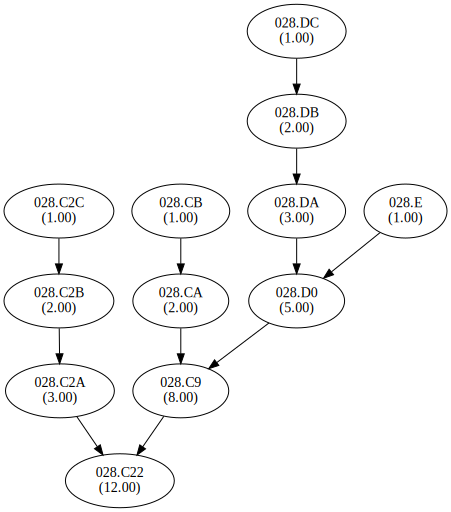

In [6]:
# Plot network labelled with accumulated flow
teo.plot_network(g, reg_id, direct="up", stat="accum", quant="diff_parx_tonnes")

The code below shows exactly the same plot, but this time labelled with accumulated fluxes for `pary`, which has a transmission factor of 0.5. Each headwater catchment therefore transmits 0.5 tonnes of `pary` to the next catchment downstream. In the next catchment, a further 1 tonne of `pary` is added, of which 0.75 tonnes are transmitted downstream. The next catchment therefore transmits $0.5 * (1 + 0.75) = 0.88$ tonnes, and so on. The total flux from the final catchment in this case is 1.67 tonnes, compared to 12 tonnes for `parx`. In other words, **the vast majority (more than 10 tonnes) of `pary` is retained in the system, even though the retention factors are all set to 0.5**. This example illustrates the importance of catchment level retention in correctly determining riverine fluxes.

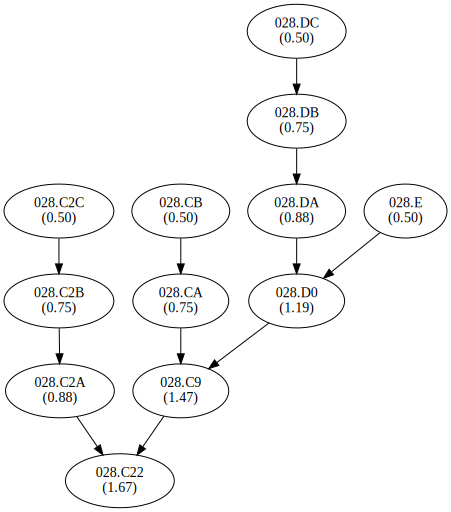

In [7]:
# Plot network labelled with accumulated flow
teo.plot_network(g, reg_id, direct="up", stat="accum", quant="diff_pary_tonnes")

### 3.3. Summary maps

TEOTIL2 also provides convenient methods for visualising results at the level of regine catchments. The code belwo shows the accumulated flux of `parx`.

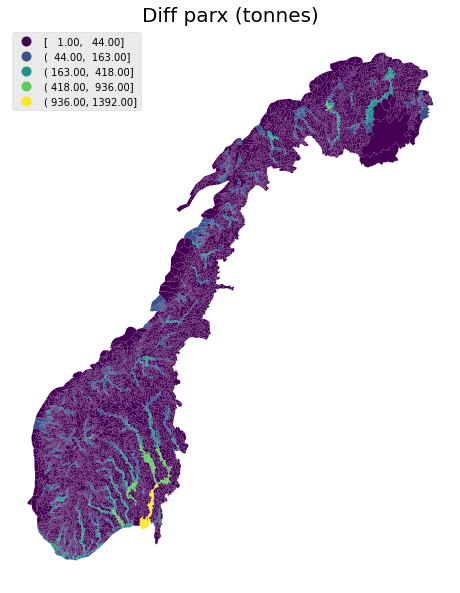

In [8]:
# Summary map of local runoff
teo.make_map(
    g,
    stat="accum",
    quant="diff_parx_tonnes",
    trans="none",
    cmap="viridis",
    scheme='natural_breaks',
    n_classes=5
)

This can be compared to the map below, which shows the accumulated flux for `pary`. Again, note the critial influence of catchment level retention: the maximum accumulated flux for `parx` is 1392 tonnes, whereas with uniform catchemnt level retention of 0.5 (for `pary`), the maximum is reduced to just 3.1 tonnes.

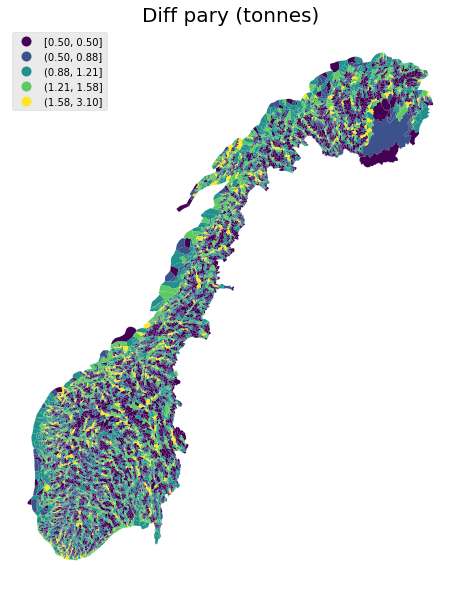

In [9]:
# Summary map of local runoff
teo.make_map(
    g,
    stat="accum",
    quant="diff_pary_tonnes",
    trans="none",
    cmap="viridis",
    scheme='natural_breaks',
    n_classes=5
)

## 4. Summary

This tutorial used "toy" data to illustrate the principles of TEOTIL2, including how the model can be easily extended to simulate any parameter of interest - as long as local inputs and retention factors can be estimated at the resolution of Norway's regine catchment units. The next tutorial shows a more practical application of the model, simulating total fluxes of nitrogen and phosphorus.